# Разбор домашнего задания по расчёту размера выборки

In [1]:
import pandahouse
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
from scipy.stats import ttest_ind

rng = np.random.default_rng()

In [2]:
# Это мы в Clickhouse ходить будем
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

Для начала вытащим данные по просмотрам и CTR за период АА-теста и подготовим их нужным образом.

In [4]:
#эмпирическое распределение просмотров

q = """
select views, count() as users
from (select  
    user_id,
    sum(action = 'view') as views
from simulator_20240620.feed_actions 
where toDate(time) between '2024-05-24' and '2024-05-30'
group by user_id
)
group by views
order by views
"""

views_distribution = pandahouse.read_clickhouse(q, connection=connection)
views_distribution['p'] = views_distribution['users']/views_distribution.users.sum()
views_distribution.head()

,views,users,p
0,1,4,0.000095
1,2,1,0.000024
2,3,4,0.000095
3,4,5,0.000119
4,5,18,0.000429


In [5]:
#CTR (оставим группировку по дате для большего разнообразия в CTR)
q = """
select 
   floor(ctr, 2) as ctr, count() as users
from (select toDate(time) as dt, 
    user_id,
    sum(action = 'like')/sum(action = 'view') as ctr
from simulator_20240620.feed_actions 
where toDate(time) between '2024-05-24' and '2024-05-30'
group by dt, user_id
)
group by ctr
"""

#эмпирическое распределение
ctr_distribution = pandahouse.read_clickhouse(q, connection=connection)
ctr_distribution['p'] = ctr_distribution['users']/ctr_distribution.users.sum()
ctr_distribution.head()

,ctr,users,p
0,0.00,1443,0.016952
1,0.65,4,0.000047
2,0.71,5,0.000059
3,0.49,4,0.000047
4,0.54,72,0.000846


Сколько у нас всего пользователей было за этот период?

In [6]:
#сколько пользователей было в АА-тесте
q = """
select uniqExact(user_id)
from simulator_20240620.feed_actions
where toDate(time) between '2024-05-24' and '2024-05-30'

"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,41997


Посмотрим, сколько это будет, если поделить пополам. Уже сразу видно, что это будет дробное число - соответственно, нам нужно его как-то округлить. 

На самом деле это не так принципиально в данном случае. На фоне пары десятков тысяч один пользователь погоды не сделает. Но округлим вниз - лучше недооценить, чем переоценить.

In [7]:
#сколько попадёт в одну группу при равной разбивке
np.floor(41997 / 2)

20998.0

Теперь давайте полюбуемся на распределения, которые мы генерируем на основе реальных. 

Начнём с просмотров. Видна явная асимметрия - и если присмотреться, то можно даже заметить небольшую двухгорбость.

<AxesSubplot:ylabel='Count'>

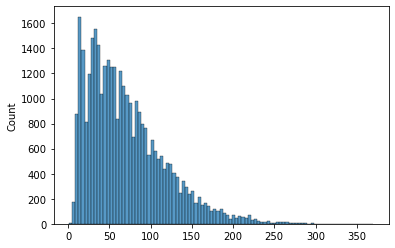

In [8]:
sim_views = rng.choice(a=views_distribution.views, size=34463, replace=True, p=views_distribution.p)
sns.histplot(sim_views)

CTR выглядят разреженными, чего стоило ожидать - ведь мы фактически округлили непрерывную величину и сэмплировали эти округлённые значения, а любые промежуточные значения генерироваться не будут. 

Можно было бы подойти к вопросу через [Kernel Denisty Estimation](https://mathisonian.github.io/kde/) - оценить плотность вероятности по выборке, а потом сэмплировать прямо оттуда. Так умеет делать [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html), [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html), а также в Python есть [специальный пакет](https://github.com/lzkelley/kalepy) под эту задачу. 

Но этот подход сам по себе непрост, а для наших текущих целей подойдёт и такое вот грубое приближение.

<AxesSubplot:ylabel='Count'>

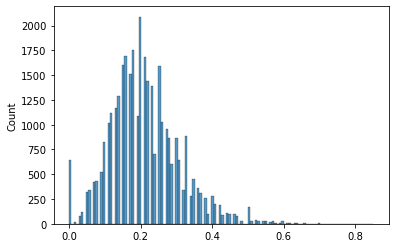

In [9]:
sim_ctrs = rng.choice(a=ctr_distribution.ctr, size=34463, replace=True, p=ctr_distribution.p)
sns.histplot(sim_ctrs)

Наконец, лайки/клики. В целом распределение похоже на распределение просмотров, но выглядит ещё более асимметричным.

<AxesSubplot:ylabel='Count'>

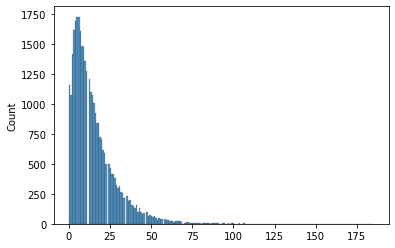

In [10]:
sim_clicks = rng.binomial(n=sim_views.astype("int64"), p=sim_ctrs)
sns.histplot(sim_clicks)

Прежде чем мы будем симулировать АБ-тестирование и считать мощности, давайте попробуем сделать искусственный АА-тест. Убедимся, что доля ложноположительных результатов (False Positive Rate, FPR) примерно равно значению альфа (0.05).

In [11]:
#функция для расчёта FPR

def fpr_calc(sample_size, views_df, ctr_df, nsim=1000):
    """
    Считает FPR для t-теста при заданных параметрах распределения
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаем FPR
    return np.mean(np.array(pvalues) < 0.05)

Результат довольно близок к ожидаемому:

In [12]:
fpr_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, nsim=20000)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:23<00:00, 61.89it/s]


0.0509

Впрочем, вы можете быть скептичны. Вдруг нам просто повезло, и на самом деле FPR ниже или выше ожидаемой границы? Чтобы убедиться, мы можем повторить эти симуляции несколько раз - и получить не только среднее значение FPR, но и доверительный интервал.

Что я собственно и сделал:

* Переписал код на [Julia](https://apptractor.ru/info/articles/yazyk-programmirovaniya-julia.html), чтобы было побыстрее
* Запустил эти симуляции параллельно на 10 ядрах
* Сделал 1000 повторов

Всё это заняло у меня суммарно примерно 4.5 часа. Такие же расчёты я делал и для наших 4 заданий - первые два считались по 5 часов, вторые два считались по 7 часов. Так что если возьмётесь заниматься этим самостоятельно - готовьтесь, что может быть долго :)

Здесь привожу только визуализацию результатов. Как видите, значения FPR действительно кучкуются около 0.05, с разбросом значений примерно +- 0.005. 

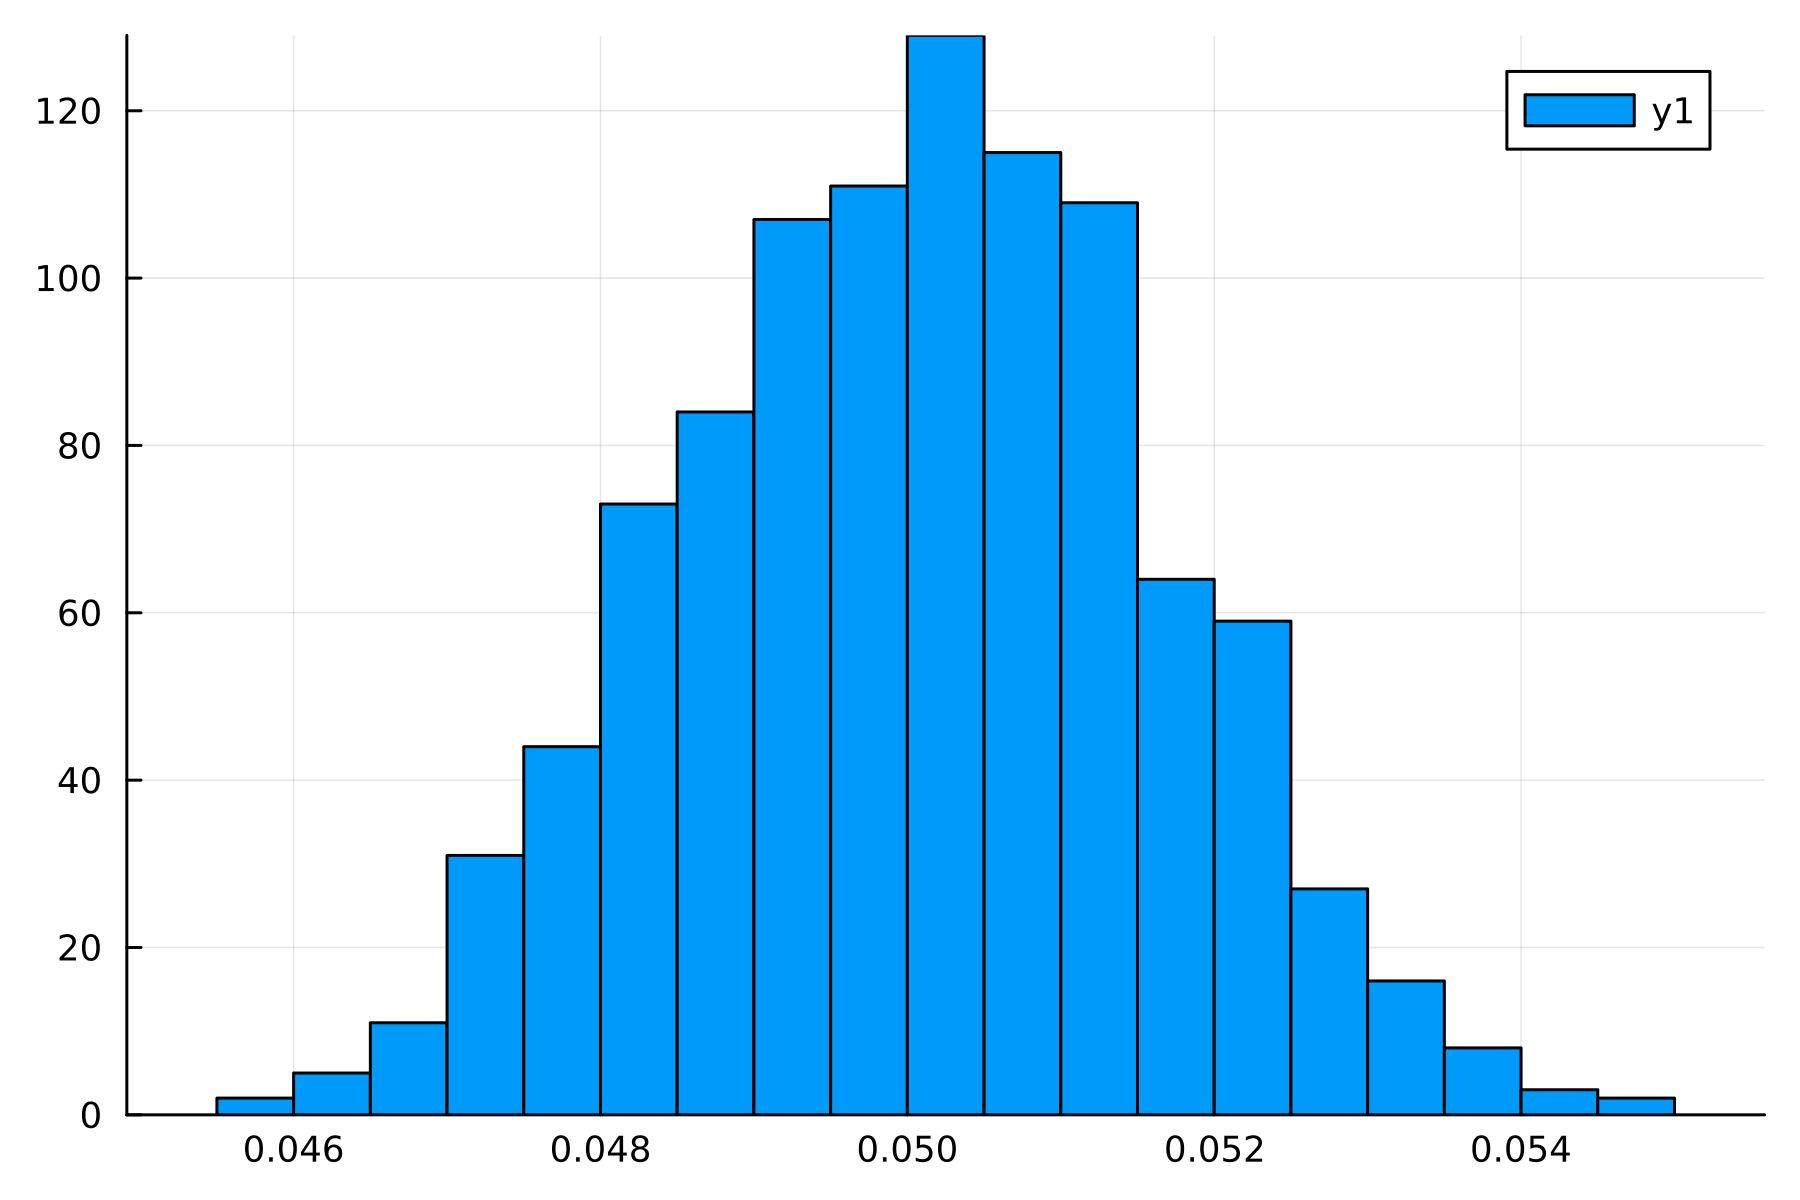

Давайте, наконец, приступим к самим заданиям.

## 1. Увеличение числа просмотров на 1-2 с 90%-ой вероятностью для пользователей с числом просмотров >=50

Давайте первым делом посмотрим на то, как такой эффект реализуется в нашей симуляции. Начнём с самого главного.

Здесь мы создаём последовательность из 1 и 2, в соотношении примерно 50/50. Фактически мы генерируем 0 и 1 с вероятностью в 50%, а потом добавляем к ним всем 1.

In [12]:
1 + rng.binomial(n=1, p=0.5, size=20998)

array([2, 2, 2, ..., 2, 2, 1], dtype=int64)

Так мы создаём "маску" из 0 и 1 - те, для кого алгоритм (не) сработал. Так как вероятность 90%, большая часть значений будет единичками.

In [13]:
rng.binomial(n=1, p=0.9, size=20998)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

Ну и, наконец, последняя "маска" - пользователи с числом просмотров большим либо равным 50. 

In [14]:
sim_views >= 50

array([ True, False,  True, ..., False, False,  True])

Когда мы всё это перемножим, у нас будет массив из 0, 1, 2, где:

* 0 - это пользователи, для которых алгоритм не сработал по одной из двух причин. Либо у него просмтров мало, либо ему просто не повезло и он попал в 10%. Возможно, даже оба варианта сразу
* 1 - один просмотр
* 2 - два просмотра

In [15]:
rng.binomial(n=1, p=0.9, size=20998) * (1 + rng.binomial(n=1, p=0.5, size=20998)) * (sim_views >= 50)

array([1, 0, 1, ..., 0, 0, 0], dtype=int64)

Приплюсовываем это к нашим просмотрам - и вот наш эффект! Потом мы на основе этого будем генерировать лайки, которые нас и интересуют в данном случае.

In [16]:
sim_views + (rng.binomial(n=1, p=0.9, size=20998) * (1 + rng.binomial(n=1, p=0.5, size=20998)) * (sim_views >= 50))

array([136.,  18.,  78., ...,  36.,  13.,  92.])

Считаем мощность:

In [13]:
def power_calc(sample_size, views_df, ctr_df, threshold, nsim=1000):
    """
    Считает мощность для t-теста при заданных параметрах распределения и эффекта
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param threshold: порог просмотров, после которого начинает действовать алгоритм
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A, clicks_B, equal_var=False).pvalue)

    #возвращаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [ ]:
power_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, threshold=50, nsim=20000)

 93%|██████████████████████████████████████████████████████████████████████▊     | 18624/20000 [05:29<00:45, 30.37it/s]

Нам стоит ожидать мощность где-то в районе 25.7%. С учётом разброса на LMS мы принимаем значения от 24% до 27%. Это чудовищно мало.

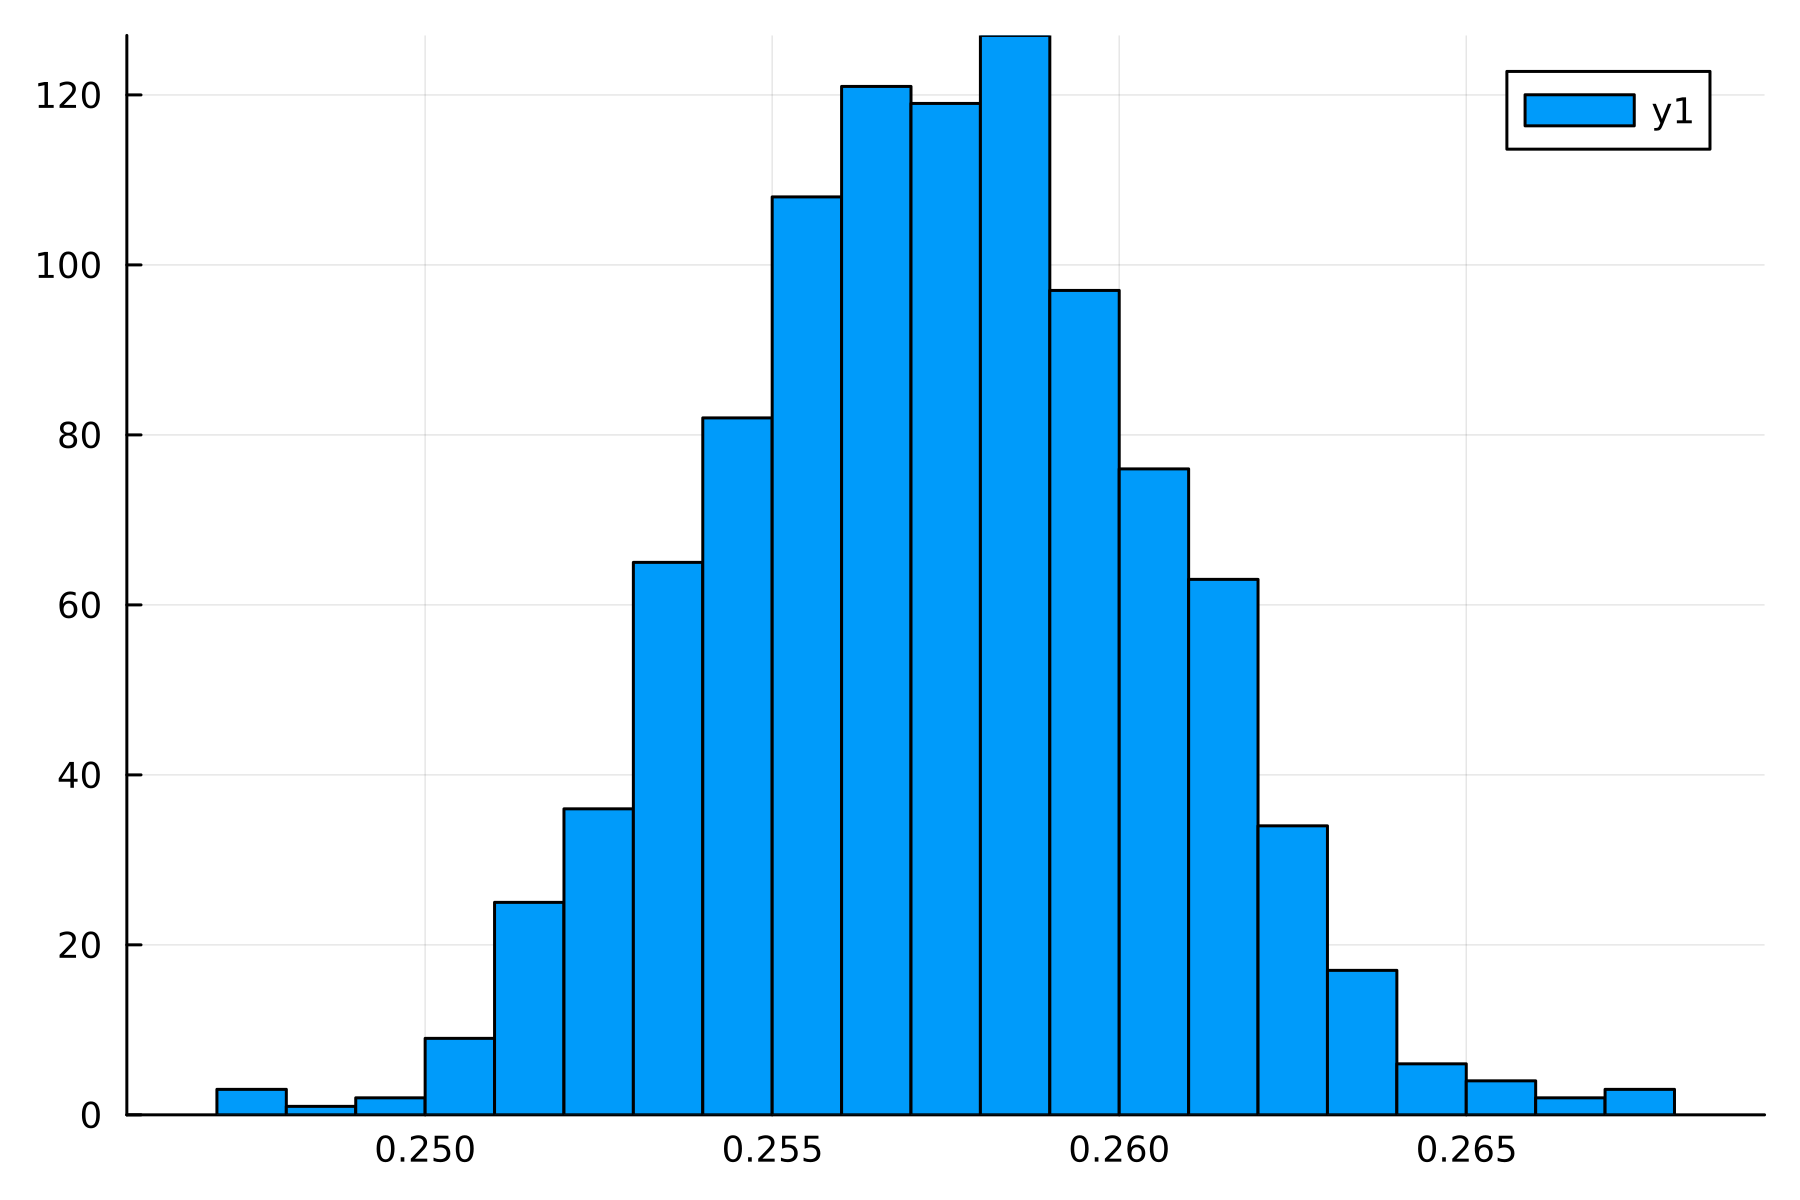

## 2. Увеличение числа просмотров на 1-2 с 90%-ой вероятностью для пользователей с числом просмотров >=30

Если вы сделали прошлое задание, то выполнить это будет просто :)

In [20]:
power_calc(sample_size=20998, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [03:22<00:00, 98.94it/s]


0.4162

Теперь у нас мощность где-то около 41.7% - то есть мы выиграли где-то 16% дополнительной мощности. С учётом разброса на LMS принимаются значения от 39.5% до 43.5%. Это всё ещё очень мало. 

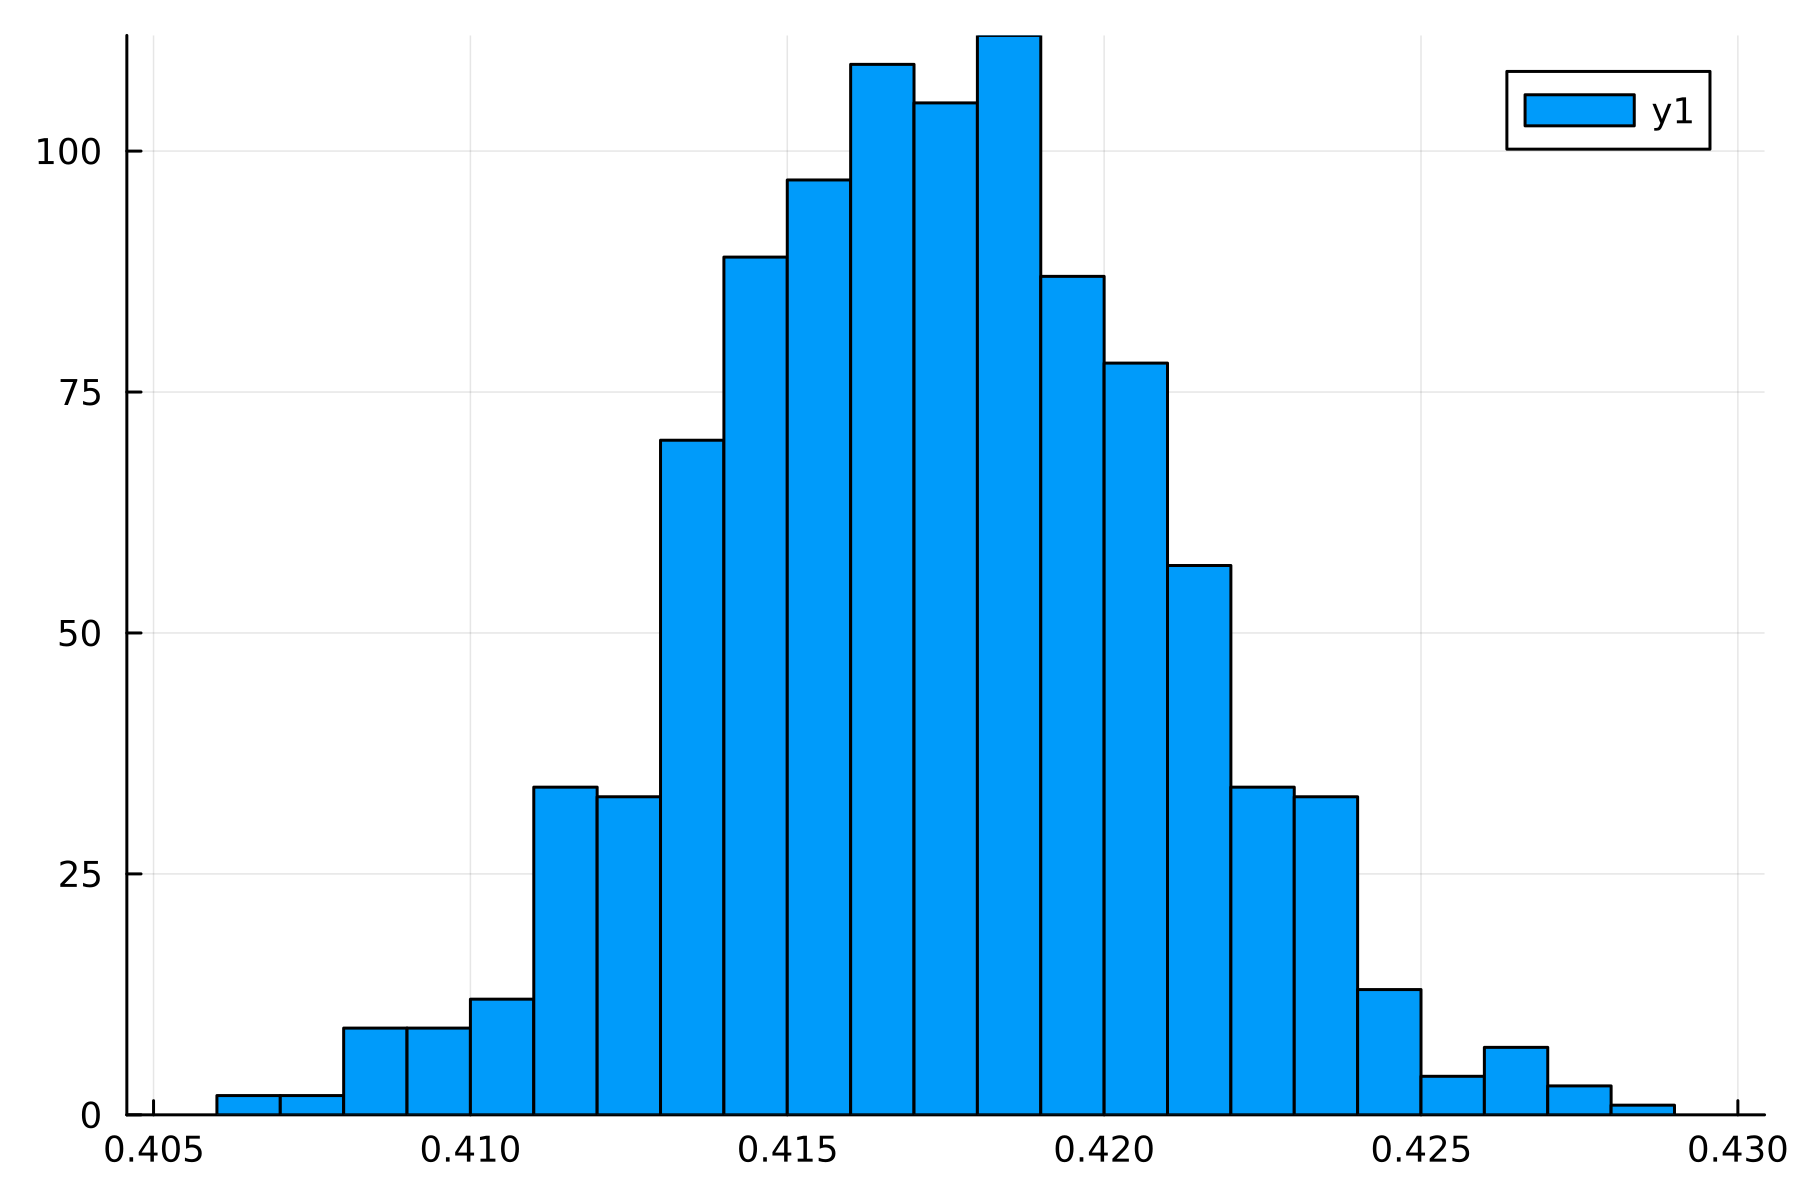

## 3. Увеличиваем длительность эксперимента до 2 недель

Как обычно, посчитаем ожидаемый размер выборки согласно условию задания:

In [21]:
q = """
select uniqExact(user_id)
from simulator_20240320.feed_actions
where toDate(time) between '2024-02-23' and '2024-03-07'

"""

pandahouse.read_clickhouse(q, connection=connection)

,uniqExact(user_id)
0,61182


In [22]:
np.floor(61182 / 2)

30591.0

Дальше всё тоже просто:

In [23]:
power_calc(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [05:02<00:00, 66.17it/s]


0.56

Мощность где-то около 56.3%. С учётом разброса на LMS принимаются значения от 54.5% до 57.5%. Мы всё ближе к цели, но заветного порога в 80% мы ещё не достигли.

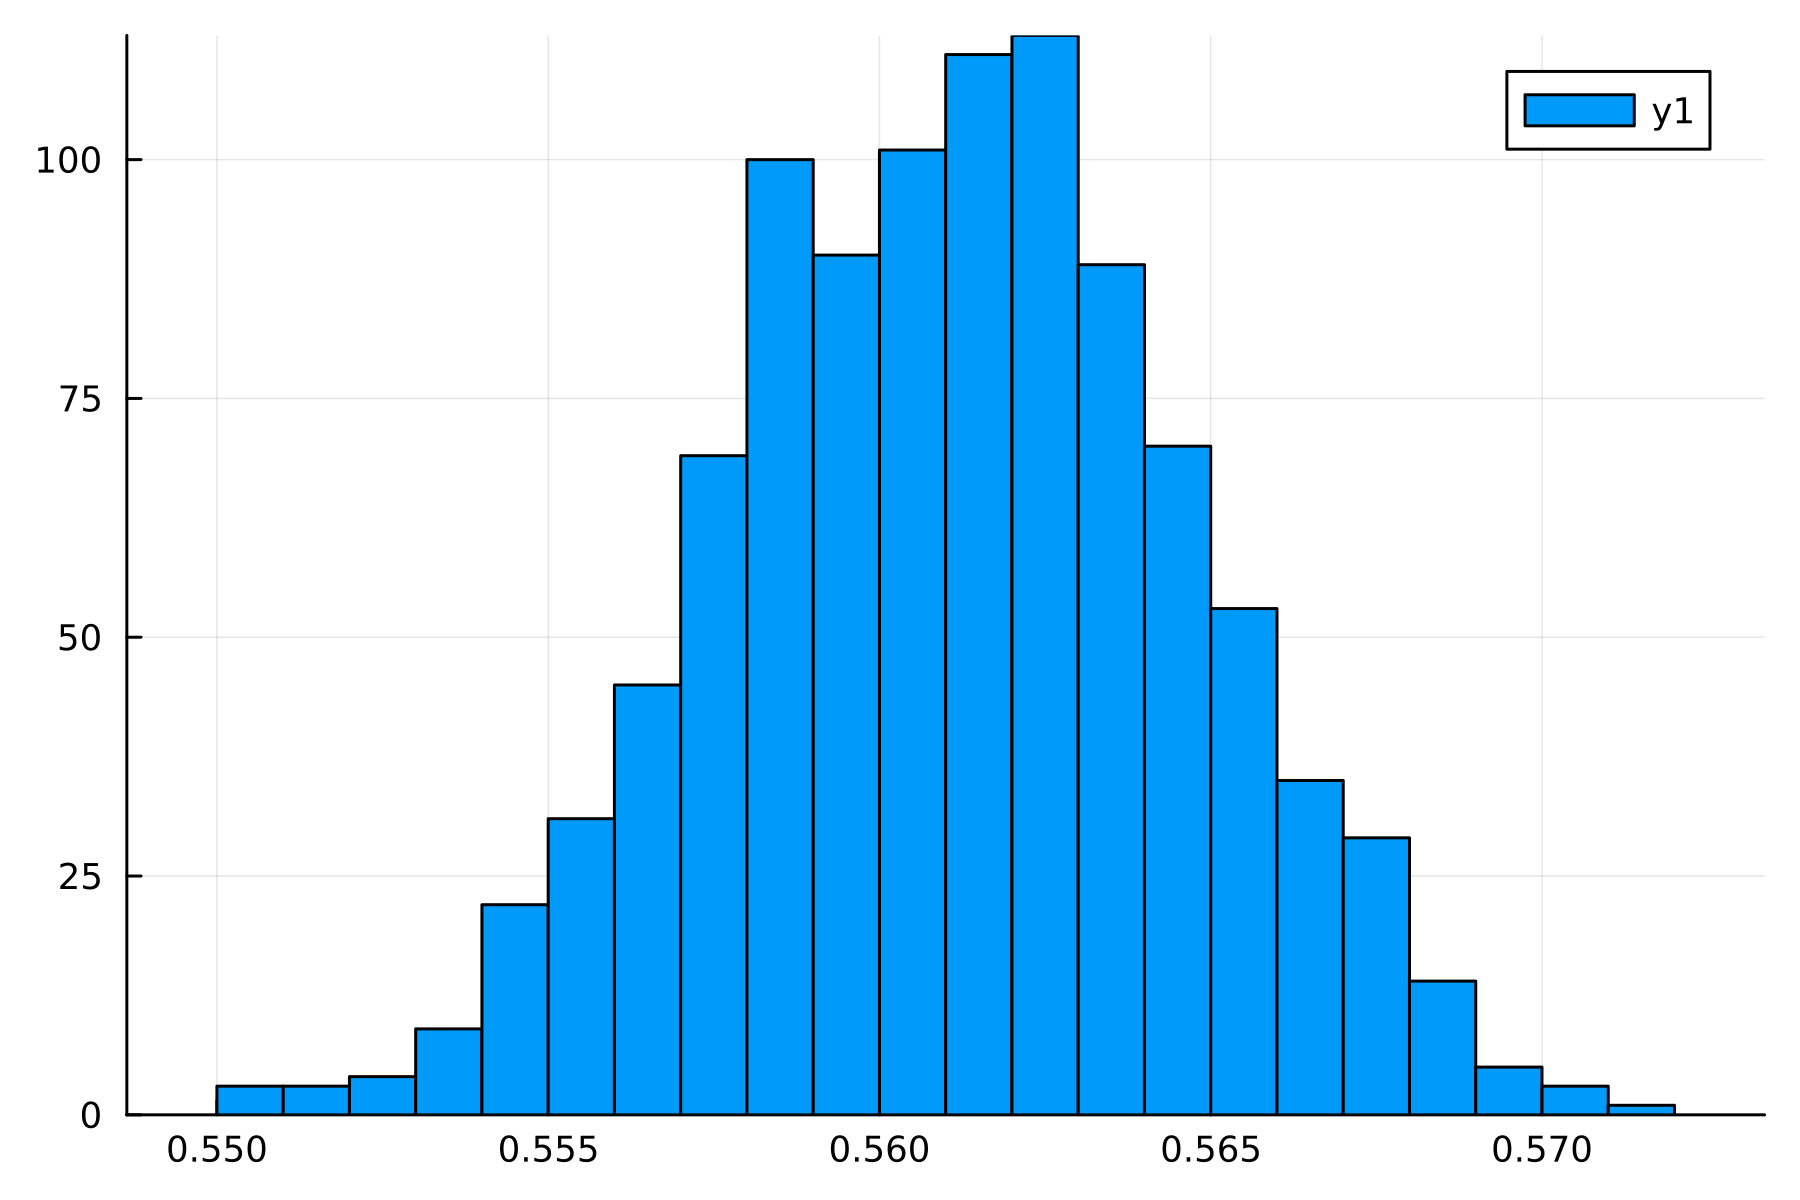

## 4. Считаем только пользователей с числом просмотров >=30

Здесь важно сделать оговорку, что хотя зачастую такое решение является хорошей идеей, это не всегда так - так как иногда пользователи, на которых мы не ожидаем эффекта, всё-таки его получают.

Пример от Яна Пиле - некоторое время назад у Яндекс.Маркета было два бренда: Яндекс.Маркет и Беру!(собственный магазин маркета - теперь он интегрирован вовнутрь Яндекс.Маркета). Маркетинговые рассылки шли с различными брендами и оформлениями (желтое у Маркета и фиолетовое у Беру). Частенько случалось так, что люди, получившие рассылки от Маркета с предложениями из товарной базы Маркета, вместо этого приходили на Беру и покупали там (хотя письма ссылок на Беру не содержали и упоминаний никаких там не было) - вплоть до того, что чек на Беру прокрашивался, а на Маркете - нет).

Как бы то ни было, считаем:

In [24]:
def power_calc_masked(sample_size, views_df, ctr_df, threshold, nsim=1000):
    """
    Считает мощность для t-теста при заданных параметрах распределения и эффекта + отсекает пользователей ниже нужного порога
    :param sample_size: размер выборок
    :param views_df: датафрейм со значениями просмотров и их вероятностями
    :param ctr_df: датафрейм со значениями прользовательских CTR и их вероятностями
    :param threshold: порог просмотров, после которого начинает действовать алгоритм
    :param nsim: количество симуляций (по умолчанию 1000)
    :return: значение мощности от 0 до 1
    """

    pvalues = [] #список, куда мы будем складывать p-value
    rng = np.random.default_rng() #генератор случайных чисел

    #симуляируем и сравниваем выборки nsim раз:

    for _ in tqdm(range(nsim)):

        #симулируем просмотры
        group_A_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")
        group_B_views = rng.choice(a=views_df.views, size=sample_size, replace=True, p=views_df.p).astype("int64")

        #симулируем эффект в тестовой группе
        group_B_views = group_B_views + (rng.binomial(n=1, p=0.9, size=sample_size) * (1 + rng.binomial(n=1, p=0.5, size=sample_size)) * (group_B_views >= threshold))
        group_B_views = group_B_views.astype("int64")

        #маска для отсеивания лишних пользователей
        mask_A = group_A_views>=threshold
        mask_B = group_B_views>=threshold

        #симулируем CTR
        group_A_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)
        group_B_ctr = rng.choice(a=ctr_df.ctr, size=sample_size, replace=True, p=ctr_df.p)

        #симулируем лайки
        clicks_A = rng.binomial(n=group_A_views, p=group_A_ctr)
        clicks_B = rng.binomial(n=group_B_views, p=group_B_ctr)

        #сравниваем t-тестом и сохраняем p-value
        pvalues.append(ttest_ind(clicks_A[mask_A], clicks_B[mask_B], equal_var=False).pvalue)

    #возвращаем мощность
    return np.mean(np.array(pvalues) < 0.05)

In [25]:
power_calc_masked(sample_size=30591, views_df=views_distribution, ctr_df=ctr_distribution, threshold=30, nsim=20000)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:56<00:00, 67.50it/s]


0.65035

Получаем где-то 64.3%. На LMS принимаются значения от 63% до 66%. 

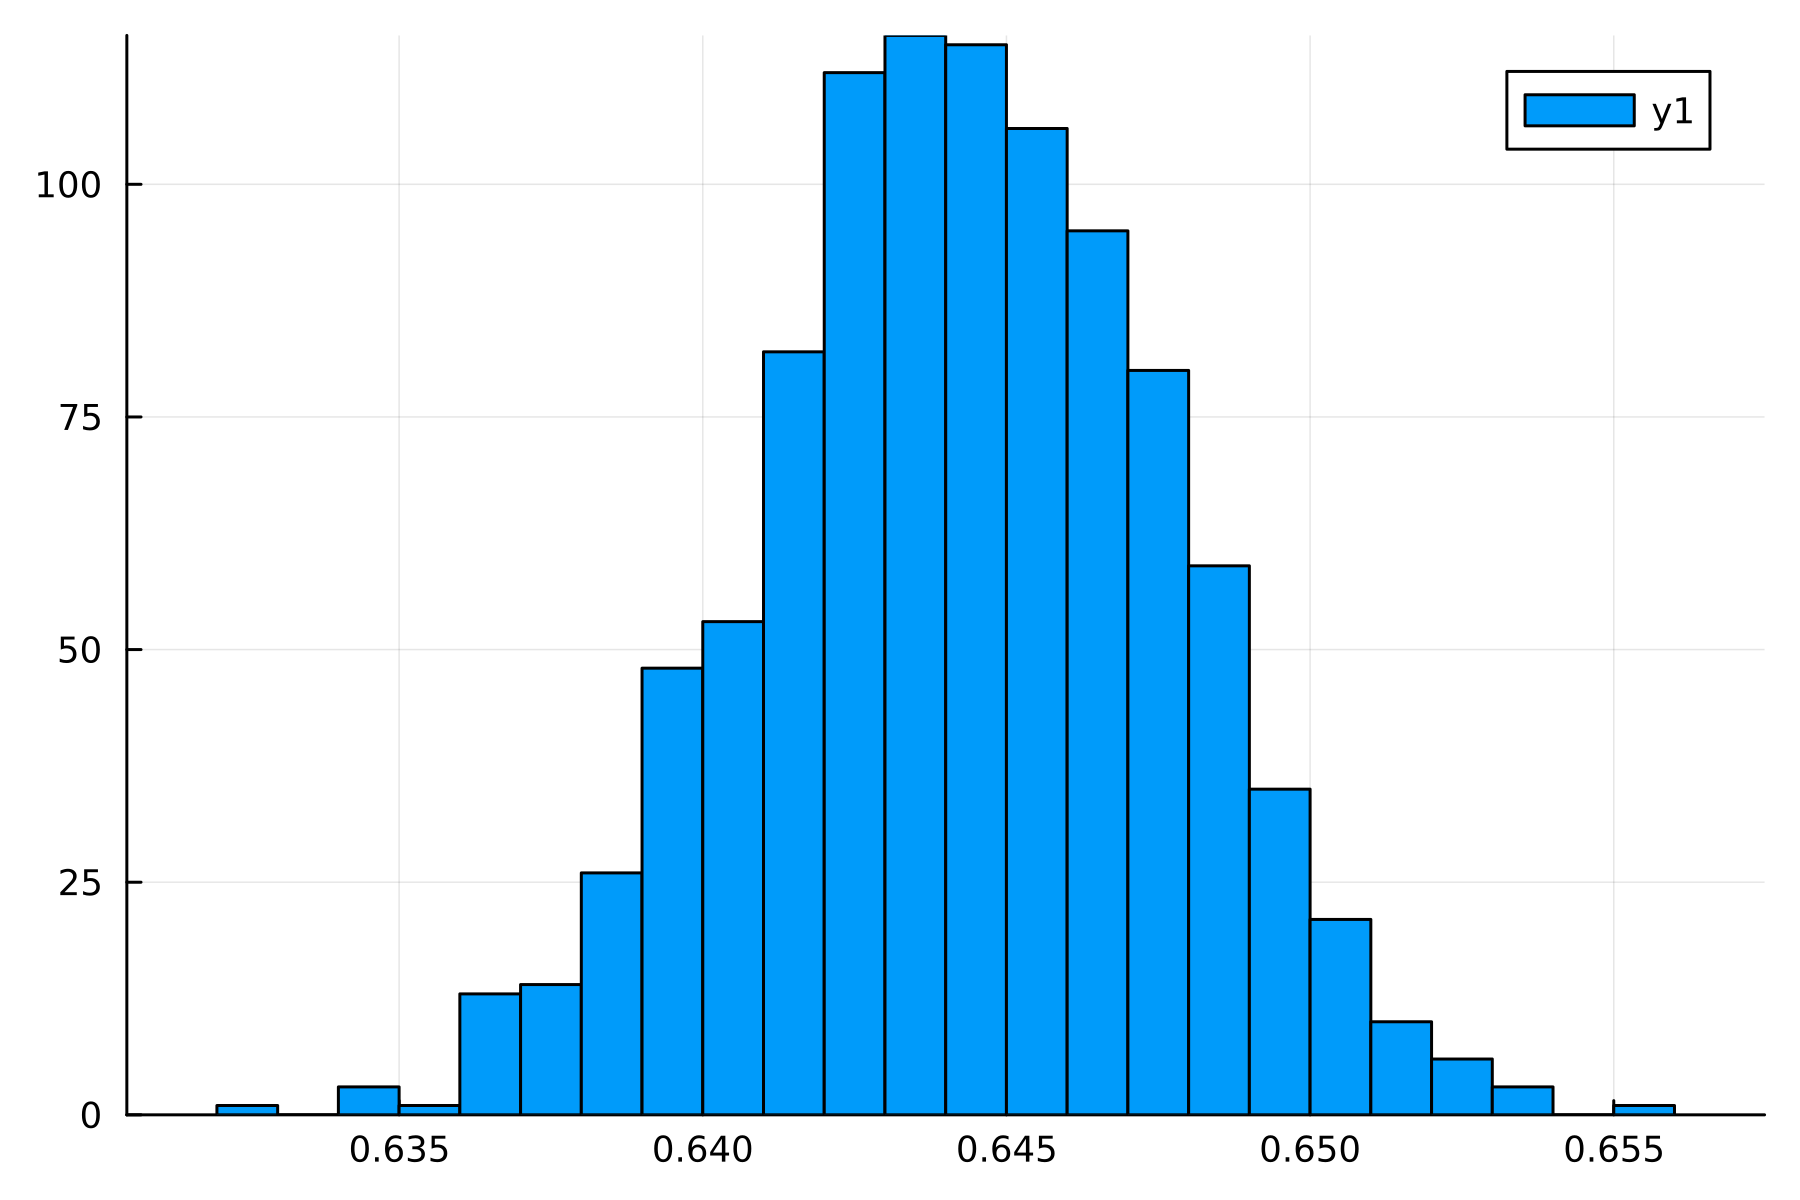

## Что делаем дальше?

Как видите, несмотря на все наши усилия, добраться до уровня мощности в 80% у нас так и не получилось. Что мы в таком случае можем предпринять?

* Отказаться от идеи эксперимента вообще. Раз у нас не хватает ресурсов для детекции такого изменения, то и смысла особо действовать нет.
* Всё равно запустить эксперимент и надеяться на лучшее. Платой за это решение будет меньшая уверенность в полученных результатах.
* Дорабатывать алгоритм, чтобы его эффект либо распространялся на большее число пользователей, либо чтобы он был больше.
* Понижать дисперсию метрики методами [стратификации](https://habr.com/ru/companies/X5Tech/articles/596279/) либо [CUPED](https://habr.com/ru/companies/X5Tech/articles/780270/). Как это симулировать - отдельный вопрос :)
* Посмотреть на актуальное количество уникальных пользователей в нашем сервисе. Всё-таки у нас был положительный тренд - возможно, на текущий момент мы можем позволить себе гораздо больше пользователей! Проверьте, сколько пользователей у вас было за последние пару недель и пересчитайте симуляцию; может, вы всё-таки можете набрать достаточное количество.
* Поменять уровень значимости на более высокий. Платой за это будет большая вероятность ложноположительного результата.
* Поменять статистический тест на другой; может, t-тест просто имеет тут недостаточно мощности. Возможно, также поможет линеаризация или какой-нибудь вариант бакетизации.
* Переписать симуляцию - возможно, вы не согласны с какими-то деталями её реализации и можете сделать лучше! Впрочем, гарантии того, что улучшение симуляции приведёт к росту оцениваемой мощности, у вас нет.